# 머신러닝을 위한 컬럼 수정 및 추가 & EDA

In [31]:
# import
import pandas as pd
import numpy as np
import re
import ast

from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import platform
from matplotlib import font_manager,rc

import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline
# 마이너스 부호 떄문에 한글이 깨질 수가 있어 설정
plt.rcParams['axes.unicode_minus'] = False

import matplotlib.font_manager as fm

# 한글 폰트 설정 (Windows 기준, 나눔 폰트 사용 예)
plt.rcParams['font.family'] = 'Malgun Gothic'


In [32]:
# 데이터 불러오기 1
df = pd.read_excel('../data/file/imdb_pca.xlsx', index_col=0)

# 딕셔너리 해제
for i in range(1, 12):
    df['season_{}'.format(i)] = df.loc[df['season_{}'.format(i)].notnull(), 'season_{}'.format(i)].apply(ast.literal_eval)

df.tail()

,korean_title,english_title,year,total_season_num,runtime,genre,age_rating,production_country,season_1,season_2,...,season_9,season_10,season_11,season_12,season_13,season_14,season_15,season_16,season_17,PCA
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
900,레일라,Leila,2019,1,46,"드라마, 전쟁, SF",15,인도,"{'S1.E1': [5.6, 322, 'Fri, Jun 14, 2019'], 'S1...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.799565
901,100만 엔의 여인들,Million Yen Women,2017,1,30,"스릴러, 범죄, 드라마, 로맨스",19,일본,"{'S1.E1': [7.6, 148, 'Fri, Apr 14, 2017'], 'S1...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.368528
902,킬러 코미디언,Hasmukh,2020,1,33,"범죄, 드라마, 스릴러, 코미디",19,인도,"{'S1.E1': [5.8, 60, 'Fri, Apr 17, 2020'], 'S1....",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.045870
903,달러,Dollar,2019,1,41,"액션, 드라마, 로맨스",15,레바논,"{'S1.E1': [8.0, 44, 'Thu, Aug 8, 2019'], 'S1.E...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.178660
904,"엘리트들, 못다 한 이야기: 나디아 구스만",Elite Short Stories: Nadia Guzmán,2021,1,11,"드라마, 로맨스",15,스페인,"{'S1.E1': [6.5, 225, 'Tue, Jun 15, 2021'], 'S1...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.633638


In [33]:
del df['season_12']
del df['season_13']
del df['season_14']
del df['season_15']
del df['season_16']
del df['season_17']

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 905 entries, 0 to 904
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   korean_title        905 non-null    object 
 1   english_title       905 non-null    object 
 2   year                905 non-null    int64  
 3   total_season_num    905 non-null    int64  
 4   runtime             905 non-null    int64  
 5   genre               905 non-null    object 
 6   age_rating          905 non-null    int64  
 7   production_country  905 non-null    object 
 8   season_1            905 non-null    object 
 9   season_2            266 non-null    object 
 10  season_3            136 non-null    object 
 11  season_4            79 non-null     object 
 12  season_5            49 non-null     object 
 13  season_6            35 non-null     object 
 14  season_7            21 non-null     object 
 15  season_8            8 non-null      object 
 16  season_9     

## 01. 연령, 장르 다양성 컬럼 수정

In [35]:
# 연령 제한 숫자로 변환
df['age_rating'] = df['age_rating'].replace('ALL', 0).astype(int)

In [36]:
# 장르 다양성 지수
def get_genre_diversity(x):
    genre_len = len(x.split(', '))
    return genre_len

In [37]:
# 장르 다양성 지수
df['genre_len'] = df['genre'].apply(get_genre_diversity)

## 02. 제작국가 인코딩(빈도, 레이블 인코딩)

In [38]:
# production_country 컬럼의 데이터를 처리하는 함수 정의
def process_countries(countries):
    # 쉼표를 기준으로 분리하고 첫 번째 나라 선택
    countries_list = countries.split(',')
    first_country = countries_list[0].strip()
    return first_country

# apply 함수를 사용하여 모든 행에 적용
df['production_country'] = df['production_country'].apply(process_countries)

In [39]:
# 빈도 인코딩 수행
country_counts = df['production_country'].value_counts()
df['production_country_freq_code'] = df['production_country'].map(country_counts)

# 인코딩된 코드 생성
df['production_country_code'], _ = pd.factorize(df['production_country'])

## 03. 시즌11까지 ML을 위한 데이터 정리

In [40]:
# 데이터 불러오기 2
watcha = pd.read_excel('../data/file/watcha.xlsx', index_col=0)

# 리스트 해제
for i in range(1, 12):
    watcha['season_{}'.format(i)] = watcha.loc[watcha['season_{}'.format(i)].notnull(), 'season_{}'.format(i)].apply(ast.literal_eval)

watcha.tail()

,korean_title,english_title,year,total_season_num,production_country,watcha_name,season_1,season_2,season_3,season_4,...,season_8,season_9,season_10,season_11,season_12,season_13,season_14,season_15,season_16,season_17
900,레일라,Leila,2019,1,인도,['레일라'],"[3.2, 27, 3]",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
901,100만 엔의 여인들,Million Yen Women,2017,1,일본,['100만 엔의 여자들'],"[3.0, 718, 100]",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
902,킬러 코미디언,Hasmukh,2020,1,인도,['킬러 코미디언'],"[1.6, 4, 0]",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
903,달러,Dollar,2019,1,레바논,['달러'],"[0.7, 3, 1]",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
904,"엘리트들, 못다 한 이야기: 나디아 구스만",Elite Short Stories: Nadia Guzmán,2021,1,스페인,"['엘리트들, 못다 한 이야기: 나디아 구스만']","[2.8, 420, 30]",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
del watcha['season_12']
del watcha['season_13']
del watcha['season_14']
del watcha['season_15']
del watcha['season_16']
del watcha['season_17']

In [42]:
# 데이터 준비

imdb_12 = df[df['season_2'].notna()]
imdb_23 = df[df['season_3'].notna()]
imdb_34 = df[df['season_4'].notna()]
imdb_45 = df[df['season_5'].notna()]
imdb_56 = df[df['season_6'].notna()]
imdb_67 = df[df['season_7'].notna()]
imdb_78 = df[df['season_8'].notna()]
imdb_89 = df[df['season_9'].notna()]
imdb_910 = df[df['season_10'].notna()]
imdb_1011 = df[df['season_11'].notna()]

In [43]:
watcha_12 = watcha[watcha['season_2'].notna()]
watcha_23 = watcha[watcha['season_3'].notna()]
watcha_34 = watcha[watcha['season_4'].notna()]
watcha_45 = watcha[watcha['season_5'].notna()]
watcha_56 = watcha[watcha['season_6'].notna()]
watcha_67 = watcha[watcha['season_7'].notna()]
watcha_78 = watcha[watcha['season_8'].notna()]
watcha_89 = watcha[watcha['season_9'].notna()]
watcha_910 = watcha[watcha['season_10'].notna()]
watcha_1011 = watcha[watcha['season_11'].notna()]

In [44]:
len(imdb_12), len(imdb_23), len(imdb_34), len(imdb_45), len(imdb_56), len(imdb_67), len(imdb_78), len(imdb_89), len(imdb_910), len(imdb_1011)

(266, 136, 79, 49, 35, 21, 8, 4, 2, 1)

In [45]:
# IMDb 필요 컬럼 정리
# 현재 시즌의 데이터로 다음 시즌의 점수를 예측하기 위해 컬럼을 설정

imdb_12.loc[:, 'present_season'] = imdb_12['season_1']
imdb_12.loc[:, 'next_season'] = imdb_12['season_2']
imdb_23.loc[:, 'present_season'] = imdb_23['season_2']
imdb_23.loc[:, 'next_season'] = imdb_23['season_3']
imdb_34.loc[:, 'present_season'] = imdb_34['season_3']
imdb_34.loc[:, 'next_season'] = imdb_34['season_4']
imdb_45.loc[:, 'present_season'] = imdb_45['season_4']
imdb_45.loc[:, 'next_season'] = imdb_45['season_5']
imdb_56.loc[:, 'present_season'] = imdb_56['season_5']
imdb_56.loc[:, 'next_season'] = imdb_56['season_6']

imdb_67.loc[:, 'present_season'] = imdb_67['season_6']
imdb_67.loc[:, 'next_season'] = imdb_67['season_7']
imdb_78.loc[:, 'present_season'] = imdb_78['season_7']
imdb_78.loc[:, 'next_season'] = imdb_78['season_8']
imdb_89.loc[:, 'present_season'] = imdb_89['season_8']
imdb_89.loc[:, 'next_season'] = imdb_89['season_9']
imdb_910.loc[:, 'present_season'] = imdb_910['season_9']
imdb_910.loc[:, 'next_season'] = imdb_910['season_10']
imdb_1011.loc[:, 'present_season'] = imdb_1011['season_10']
imdb_1011.loc[:, 'next_season'] = imdb_1011['season_11']

In [46]:
# watcha 필요 컬럼 IMDb에 추가

imdb_12.loc[:, 'w_present_season'] = watcha_12['season_1']
imdb_12.loc[:, 'w_next_season'] = watcha_12['season_2']
imdb_23.loc[:, 'w_present_season'] = watcha_23['season_2']
imdb_23.loc[:, 'w_next_season'] = watcha_23['season_3']
imdb_34.loc[:, 'w_present_season'] = watcha_34['season_3']
imdb_34.loc[:, 'w_next_season'] = watcha_34['season_4']
imdb_45.loc[:, 'w_present_season'] = watcha_45['season_4']
imdb_45.loc[:, 'w_next_season'] = watcha_45['season_5']
imdb_56.loc[:, 'w_present_season'] = watcha_56['season_5']
imdb_56.loc[:, 'w_next_season'] = watcha_56['season_6']

imdb_67.loc[:, 'w_present_season'] = watcha_67['season_6']
imdb_67.loc[:, 'w_next_season'] = watcha_67['season_7']
imdb_78.loc[:, 'w_present_season'] = watcha_78['season_7']
imdb_78.loc[:, 'w_next_season'] = watcha_78['season_8']
imdb_89.loc[:, 'w_present_season'] = watcha_89['season_8']
imdb_89.loc[:, 'w_next_season'] = watcha_89['season_9']
imdb_910.loc[:, 'w_present_season'] = watcha_910['season_9']
imdb_910.loc[:, 'w_next_season'] = watcha_910['season_10']
imdb_1011.loc[:, 'w_present_season'] = watcha_1011['season_10']
imdb_1011.loc[:, 'w_next_season'] = watcha_1011['season_11']

In [47]:
# 모든 데이터프레임 하나로 결합

imdb = pd.concat([imdb_12, imdb_23, imdb_34, imdb_45, imdb_56, imdb_67, imdb_78, imdb_89, imdb_910, imdb_1011], axis=0, ignore_index=True)

In [48]:
del imdb['season_1']
del imdb['season_2']
del imdb['season_3']
del imdb['season_4']
del imdb['season_5']
del imdb['season_6']
del imdb['season_7']
del imdb['season_8']
del imdb['season_9']
del imdb['season_10']
del imdb['season_11']

In [49]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 601 entries, 0 to 600
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   korean_title                  601 non-null    object 
 1   english_title                 601 non-null    object 
 2   year                          601 non-null    int64  
 3   total_season_num              601 non-null    int64  
 4   runtime                       601 non-null    int64  
 5   genre                         601 non-null    object 
 6   age_rating                    601 non-null    int32  
 7   production_country            601 non-null    object 
 8   PCA                           601 non-null    float64
 9   genre_len                     601 non-null    int64  
 10  production_country_freq_code  601 non-null    int64  
 11  production_country_code       601 non-null    int64  
 12  present_season                601 non-null    object 
 13  next_

## 04. 각 시즌 Num 컬럼 추가

In [50]:
# 첫 번째 키값에서 숫자만 추출하는 함수 정의
def get_season_number(season_dict):
    first_key = list(season_dict.keys())[0]
    season_number = re.search(r'S(\d+)', first_key).group(1)
    return season_number

# 새로운 컬럼에 시즌 숫자만 추가
imdb['seson_n'] = imdb['next_season'].apply(get_season_number)

print(imdb[['korean_title', 'next_season', 'seson_n']])

           korean_title                                        next_season  \
0    스위트 투스: 사슴뿔을 가진 소년  {'S2.E1': [7.2, 909, 'Thu, Apr 27, 2023'], 'S2...   
1                  스위트홈  {'S2.E1': [6.7, 450, 'Fri, Dec 1, 2023'], 'S2....   
2                  굿 닥터  {'S2.E1': [8.1, 1700, 'Mon, Sep 24, 2018'], 'S...   
3                 워킹 데드  {'S2.E1': [8.5, 16000, 'Sun, Oct 16, 2011'], '...   
4      비르기트: 왕국, 권력, 영광  {'S2.E1': [7.9, 522, 'Sun, Sep 25, 2011'], 'S2...   
..                  ...                                                ...   
596                  슈츠  {'S9.E1': [8.0, 1400, 'Wed, Jul 17, 2019'], 'S...   
597               블랙리스트  {'S9.E1': [7.1, 1400, 'Thu, Oct 21, 2021'], 'S...   
598               워킹 데드  {'S10.E1': [7.4, 8500, 'Sun, Oct 6, 2019'], 'S...   
599               블랙리스트  {'S10.E1': [7.7, 1000, 'Sun, Feb 26, 2023'], '...   
600               워킹 데드  {'S11.E1': [8.3, 10000, 'Sun, Aug 15, 2021'], ...   

    seson_n  
0         2  
1         2  
2         2  
3      

In [51]:
imdb['season_1'] = imdb['present_season'] 
imdb['season_2'] = imdb['next_season']

## 05. IMDb,watcha 시즌 정보(평점, 평점 창여 인원) 정리

In [52]:
# IMDb 평점
def get_imdb_rate(x):
    imdb_rate_lst = []

    # 딕셔너리에서 평점 부분만 가져옴
    for idx, val in x.items():
        imdb_rate_lst.append(val[0])

    # 시즌 평점 평균 구하기
    imdb_rate = np.mean(imdb_rate_lst)

    return imdb_rate

# IMDb 평점 매긴 사람 수
def get_imdb_rate_cnt(x):
    imdb_rate_cnt_lst = []

    # 딕셔너리에서 평점 매긴 사람만 가져옴
    for idx, val in x.items():
        imdb_rate_cnt_lst.append(val[1])


    # 평점을 매긴 사람의 시즌 평균 구하기
    imdb_rate_cnt = np.mean(imdb_rate_cnt_lst)

    return imdb_rate_cnt

In [53]:
# 이전 시즌 평점 계산
imdb['i_s1_rate'] = imdb['season_1'].apply(get_imdb_rate)
imdb['i_s1_rate_cnt'] = imdb['season_1'].apply(get_imdb_rate_cnt)

# 다음 시즌 평점 계산
imdb['i_s2_rate'] = imdb['season_2'].apply(get_imdb_rate)
imdb['i_s2_rate_cnt'] = imdb['season_2'].apply(get_imdb_rate_cnt)

In [54]:
# 왓챠 평점
def get_watcha_rate(x):
    watcha_tmp = x
    watcha_rate = watcha_tmp[0]
    return watcha_rate

In [55]:
# 왓챠 평점을 매긴 사람 수
def get_watcha_rate_cnt(x):
    watcha_tmp = x
    watcha_rate_cnt = watcha_tmp[1]
    return watcha_rate_cnt

In [56]:
imdb['w_s1_rate'] = imdb['w_present_season'].apply(get_watcha_rate)
imdb['w_s1_rate_cnt'] = imdb['w_present_season'].apply(get_watcha_rate_cnt)

In [57]:
imdb['w_s2_rate'] = imdb['w_next_season'].apply(get_watcha_rate)
imdb['w_s2_rate_cnt'] = imdb['w_next_season'].apply(get_watcha_rate_cnt)

In [ ]:
# # 시즌 1과 시즌 2의 평균 평점 및 조회수 추출
# s1_avg_rating = df['s1_avg_rating']
# s2_avg_rating = df['s2_avg_rating']
# s1_avg_views = df['s1_avg_views']
# s2_avg_views = df['s2_avg_views']

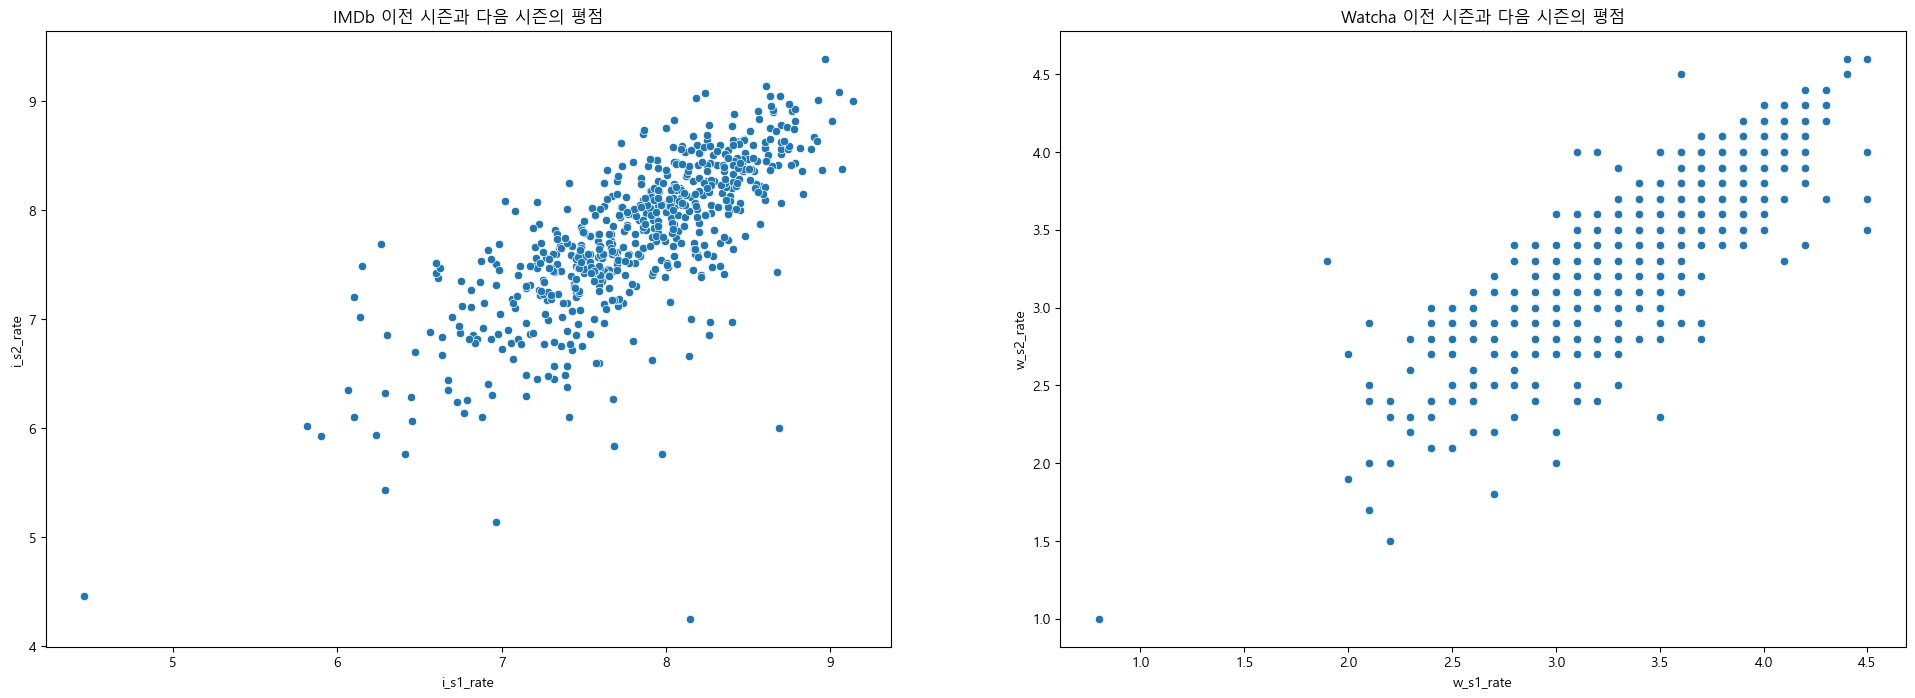

In [58]:
# Figure와 subplot 생성
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

# 첫 번째 subplot
sns.scatterplot(data=imdb, x='i_s1_rate', y='i_s2_rate', ax=axes[0])
axes[0].set_title('IMDb 이전 시즌과 다음 시즌의 평점')
axes[0].set_xlabel('i_s1_rate')
axes[0].set_ylabel('i_s2_rate')

# 두 번째 subplot
sns.scatterplot(data=imdb, x='w_s1_rate', y='w_s2_rate', ax=axes[1])
axes[1].set_title('Watcha 이전 시즌과 다음 시즌의 평점')
axes[1].set_xlabel('w_s1_rate')
axes[1].set_ylabel('w_s2_rate')

# 그래프 출력
plt.show()

# # 상관계수 계산
# views_corr = s1_avg_views.corr(s2_avg_views)
# print(f"Correlation between Season 1 and Season 2 Average Views: {views_corr}")

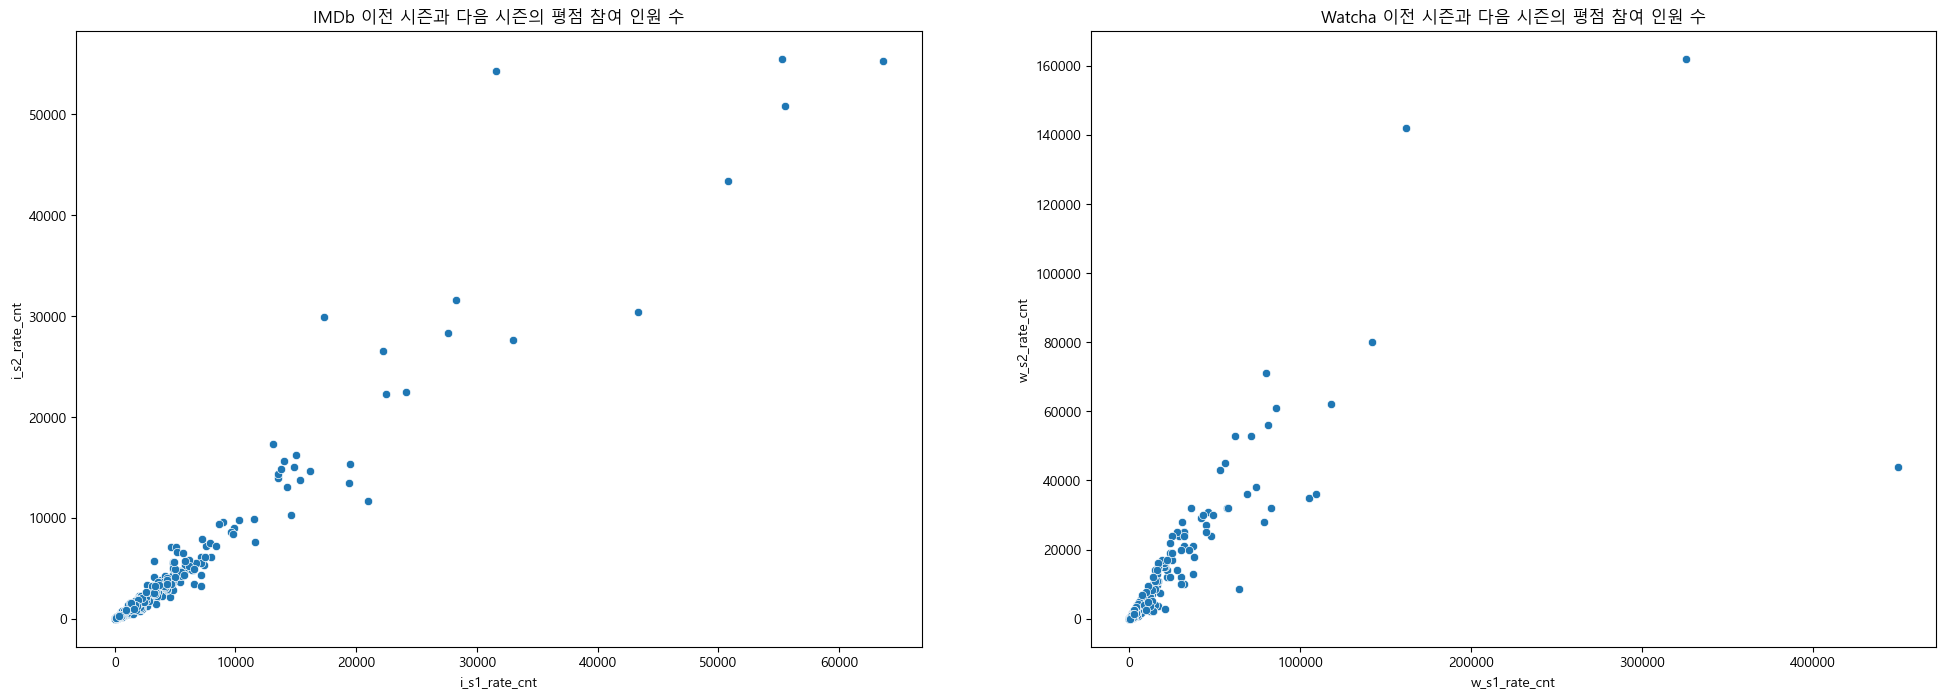

In [59]:
# Figure와 subplot 생성
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

# 첫 번째 subplot
sns.scatterplot(data=imdb, x='i_s1_rate_cnt', y='i_s2_rate_cnt', ax=axes[0])
axes[0].set_title('IMDb 이전 시즌과 다음 시즌의 평점 참여 인원 수')
axes[0].set_xlabel('i_s1_rate_cnt')
axes[0].set_ylabel('i_s2_rate_cnt')

# 두 번째 subplot
sns.scatterplot(data=imdb, x='w_s1_rate_cnt', y='w_s2_rate_cnt', ax=axes[1])
axes[1].set_title('Watcha 이전 시즌과 다음 시즌의 평점 참여 인원 수')
axes[1].set_xlabel('w_s1_rate_cnt')
axes[1].set_ylabel('w_s2_rate_cnt')

# 그래프 출력
plt.show()

## 06. 유지도

In [60]:
# 평점 유지도
def get_rate_retention(x):
    imdb_tmp = list(x.values())
    k = len(imdb_tmp)
    score = (imdb_tmp[k-1][0] / imdb_tmp[0][0])
    return score

# 평점 매긴 사람 수의 유지도(참여 유지도)
def get_rate_cnt_retention(x):
    imdb_tmp = list(x.values())
    k = len(imdb_tmp)
    score = (imdb_tmp[k-1][1] / imdb_tmp[0][1])
    return score

In [61]:
imdb['s1_rate_retention'] = imdb['season_1'].apply(get_rate_retention)
imdb['s1_rate_cnt_retention'] = imdb['season_1'].apply(get_rate_cnt_retention)

imdb['s2_rate_retention'] = imdb['season_2'].apply(get_rate_retention)
imdb['s2_rate_cnt_retention'] = imdb['season_2'].apply(get_rate_cnt_retention)

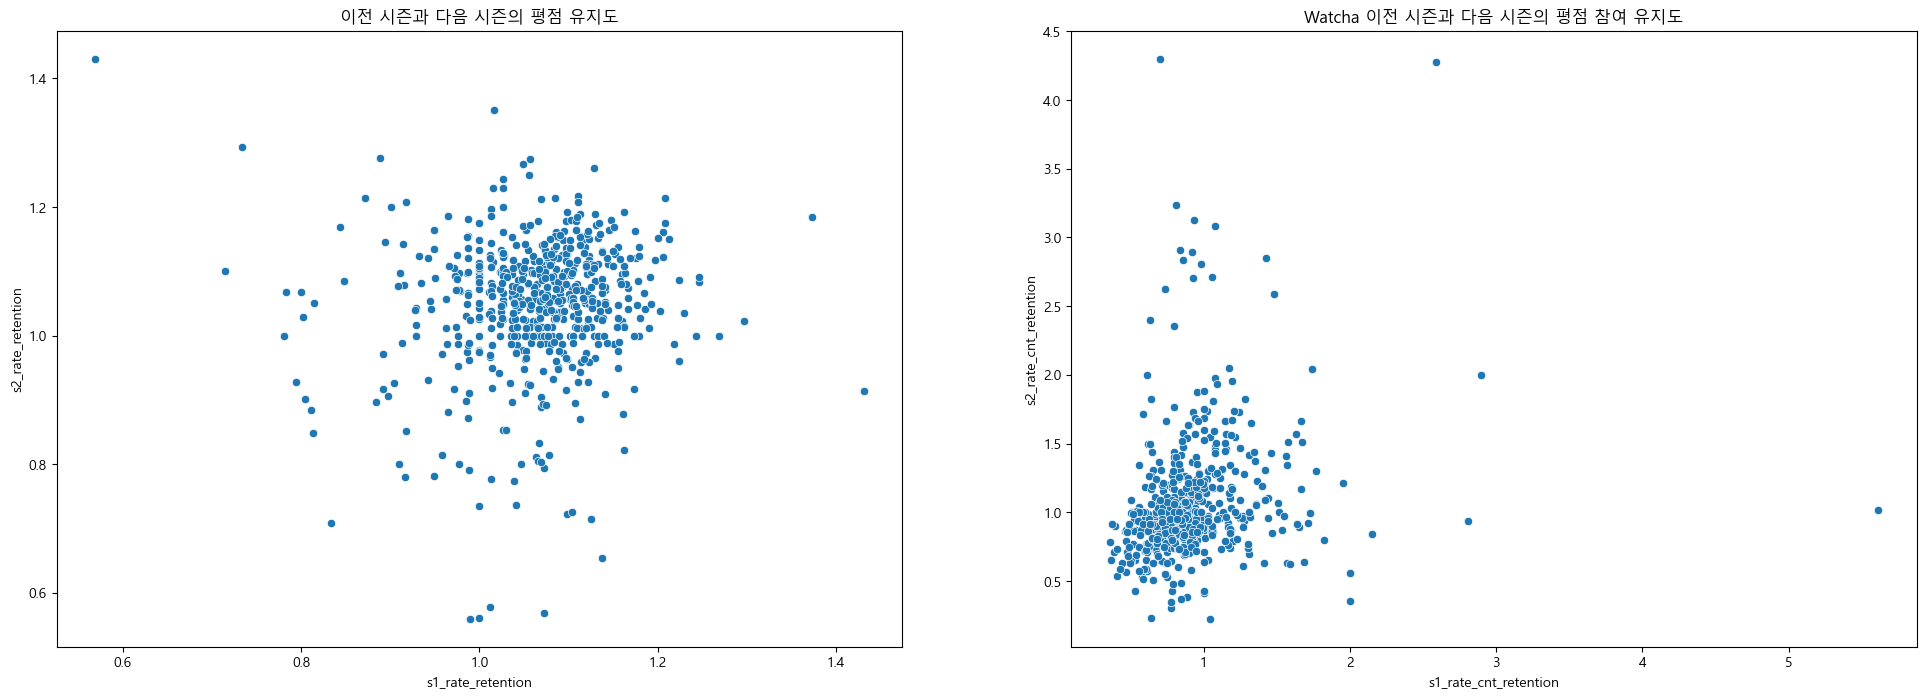

In [62]:
# Figure와 subplot 생성
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

# 첫 번째 subplot
sns.scatterplot(data=imdb, x='s1_rate_retention', y='s2_rate_retention', ax=axes[0])
axes[0].set_title('이전 시즌과 다음 시즌의 평점 유지도')
axes[0].set_xlabel('s1_rate_retention')
axes[0].set_ylabel('s2_rate_retention')

# 두 번째 subplot
sns.scatterplot(data=imdb, x='s1_rate_cnt_retention', y='s2_rate_cnt_retention', ax=axes[1])
axes[1].set_title('Watcha 이전 시즌과 다음 시즌의 평점 참여 유지도')
axes[1].set_xlabel('s1_rate_cnt_retention')
axes[1].set_ylabel('s2_rate_cnt_retention')

# 그래프 출력
plt.show()

## 07. 시즌 내 Term

In [63]:
from datetime import datetime
# 각 에피소드의 방영일자를 추출하여 처음과 마지막 방영일자를 계산하는 함수 정의
def get_first_last_air_dates(x):
    air_dates = []
    
    for episode in x.values():
        air_date_str = episode[2]
        
        # 여러 날짜 형식을 시도
        for fmt in ("%a, %b %d, %Y", "%b %Y"):
            try:
                air_date = datetime.strptime(air_date_str, fmt)
                air_dates.append(air_date)
                break
            except ValueError:
                continue
    
    if not air_dates:
        return None, None  # 변환 가능한 날짜가 없으면 None 반환
    
    first_air_date = min(air_dates)
    last_air_date = max(air_dates)
    
    return first_air_date, last_air_date

# apply 함수를 사용하여 각 행에 대해 처음과 마지막 방영일자를 계산
imdb['first_air_date'], imdb['last_air_date'] = zip(*imdb['season_1'].apply(get_first_last_air_dates))

print(imdb[['first_air_date', 'last_air_date']])

# gap_days 계산
imdb['s1_gap_days'] = (imdb['last_air_date'] - imdb['first_air_date']).dt.days

print(imdb[['first_air_date', 'last_air_date', 's1_gap_days']])

    first_air_date last_air_date
0       2021-06-04    2021-06-04
1       2020-12-18    2020-12-18
2       2017-10-02    2021-07-12
3       2010-11-07    2019-10-08
4       2010-10-10    2012-01-08
..             ...           ...
596     2018-07-18    2019-02-27
597     2020-11-13    2021-06-23
598     2018-10-07    2019-03-31
599     2021-10-21    2022-05-27
600     2019-10-06    2021-04-04

[601 rows x 2 columns]
    first_air_date last_air_date  s1_gap_days
0       2021-06-04    2021-06-04            0
1       2020-12-18    2020-12-18            0
2       2017-10-02    2021-07-12         1379
3       2010-11-07    2019-10-08         3257
4       2010-10-10    2012-01-08          455
..             ...           ...          ...
596     2018-07-18    2019-02-27          224
597     2020-11-13    2021-06-23          222
598     2018-10-07    2019-03-31          175
599     2021-10-21    2022-05-27          218
600     2019-10-06    2021-04-04          546

[601 rows x 3 columns]


In [64]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 601 entries, 0 to 600
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   korean_title                  601 non-null    object        
 1   english_title                 601 non-null    object        
 2   year                          601 non-null    int64         
 3   total_season_num              601 non-null    int64         
 4   runtime                       601 non-null    int64         
 5   genre                         601 non-null    object        
 6   age_rating                    601 non-null    int32         
 7   production_country            601 non-null    object        
 8   PCA                           601 non-null    float64       
 9   genre_len                     601 non-null    int64         
 10  production_country_freq_code  601 non-null    int64         
 11  production_country_code       60

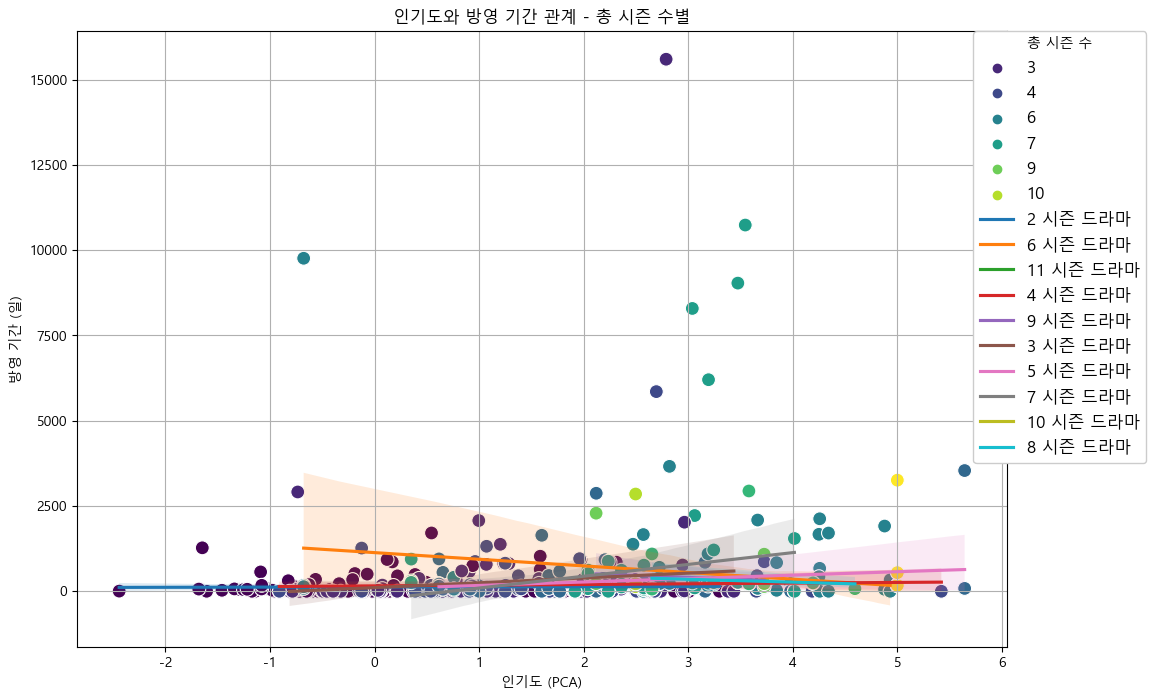

In [65]:
# 그래프 사이즈 설정
plt.figure(figsize=(12, 8))

# scatterplot with hue
sns.scatterplot(x='PCA', y='s1_gap_days', hue='total_season_num', data=imdb, palette='viridis', s=100)

# regplot for each season type
for season_num in imdb['total_season_num'].unique():
    subset_data = imdb[imdb['total_season_num'] == season_num]
    sns.regplot(x='PCA', y='s1_gap_days', data=subset_data, scatter=False,
                label=f'{season_num} 시즌 드라마' if season_num > 1 else '단일 시즌 드라마')

plt.title('인기도와 방영 기간 관계 - 총 시즌 수별')
plt.xlabel('인기도 (PCA)')
plt.ylabel('방영 기간 (일)')
plt.legend(title='총 시즌 수', fontsize='large', loc='upper right', bbox_to_anchor=(1.15, 1), borderaxespad=0., framealpha=1)
plt.grid(True)
plt.show()


## 08. 시즌간의 term

In [66]:
import pandas as pd
from datetime import datetime

# 시즌 간격 계산을 위한 컬럼 추가
imdb['season_gaps_days'] = None

for idx, row in imdb.iterrows():
    try:
        # 첫 번째 시즌의 마지막 에피소드 방영일자
        last_episode_s1 = list(row['season_1'].values())[-1][2]
        if last_episode_s1:
            last_air_date_s1 = datetime.strptime(last_episode_s1, "%a, %b %d, %Y")
        else:
            continue

        # 두 번째 시즌의 첫 번째 에피소드 방영일자
        first_episode_s2 = list(row['season_2'].values())[0][2]
        if first_episode_s2:
            next_air_date_s2 = datetime.strptime(first_episode_s2, "%a, %b %d, %Y")
        else:
            continue

        # 시즌 간의 간격 계산
        gap_days = (next_air_date_s2 - last_air_date_s1).days
        
        # imdb 데이터프레임에 간격 저장
        imdb.at[idx, 'season_gaps_days'] = gap_days

    except KeyError as e:
        print(f"KeyError: {e} in row {idx} for season 1 to season 2")
    except ValueError as e:
        print(f"ValueError: {e} in row {idx} for season 1 to season 2")

# 결과 확인
print(imdb[['korean_title', 'english_title', 'season_gaps_days']].head())

         korean_title           english_title season_gaps_days
0  스위트 투스: 사슴뿔을 가진 소년             Sweet Tooth              692
1                스위트홈              Sweet Home             1078
2                굿 닥터         The Good Doctor              182
3               워킹 데드        The Walking Dead              315
4    비르기트: 왕국, 권력, 영광  Borgen - Power & Glory              301


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


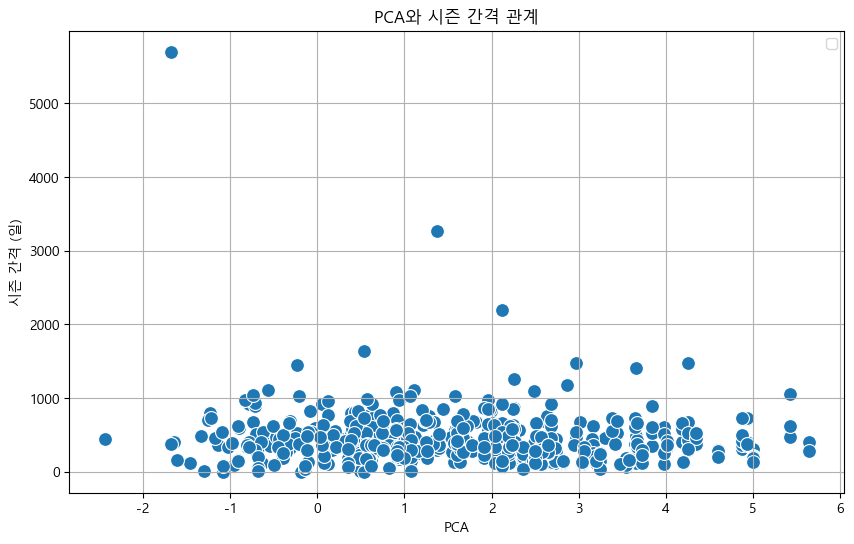

In [67]:
# 그래프 사이즈 설정
plt.figure(figsize=(10, 6))

# scatterplot 그리기
sns.scatterplot(x='PCA', y='season_gaps_days', data=imdb, palette='viridis', s=100)

# # 추세선 추가 (전체 데이터)
# sns.regplot(x='PCA', y='season_gaps_days', data=imdb, scatter_kws={'s': 0}, color='blue', label='추세선')

plt.title('PCA와 시즌 간격 관계')
plt.xlabel('PCA')
plt.ylabel('시즌 간격 (일)')
plt.legend()
plt.grid(True)
plt.show()

- term과 성공지표랑은 상관없어 보임
- 시즌의 term은 대부분 0~1000일 사이라는 것을 알 수 있음

In [68]:
del imdb['first_air_date']
del imdb['last_air_date']
del imdb['present_season']
del imdb['next_season']
del imdb['season_1']
del imdb['season_2']

In [69]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 601 entries, 0 to 600
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   korean_title                  601 non-null    object 
 1   english_title                 601 non-null    object 
 2   year                          601 non-null    int64  
 3   total_season_num              601 non-null    int64  
 4   runtime                       601 non-null    int64  
 5   genre                         601 non-null    object 
 6   age_rating                    601 non-null    int32  
 7   production_country            601 non-null    object 
 8   PCA                           601 non-null    float64
 9   genre_len                     601 non-null    int64  
 10  production_country_freq_code  601 non-null    int64  
 11  production_country_code       601 non-null    int64  
 12  w_present_season              601 non-null    object 
 13  w_nex

In [70]:
del imdb['w_present_season']
del imdb['w_next_season']

---

In [71]:
# 저장

# imdb.to_excel('../data/file/ml_all_data.xlsx')

---

# 단일, 시즌제 드라마 비교 term

In [72]:
# 엑셀 파일을 읽어옵니다.
df = pd.read_excel('../data/file/imdb_pca_1.xlsx', index_col=0)

In [73]:
# 딕셔너리 해제
for i in range(1, 12):
    df['season_{}'.format(i)] = df.loc[df['season_{}'.format(i)].notnull(), 'season_{}'.format(i)].apply(ast.literal_eval)

### 01. 시즌 내의 term 비교 

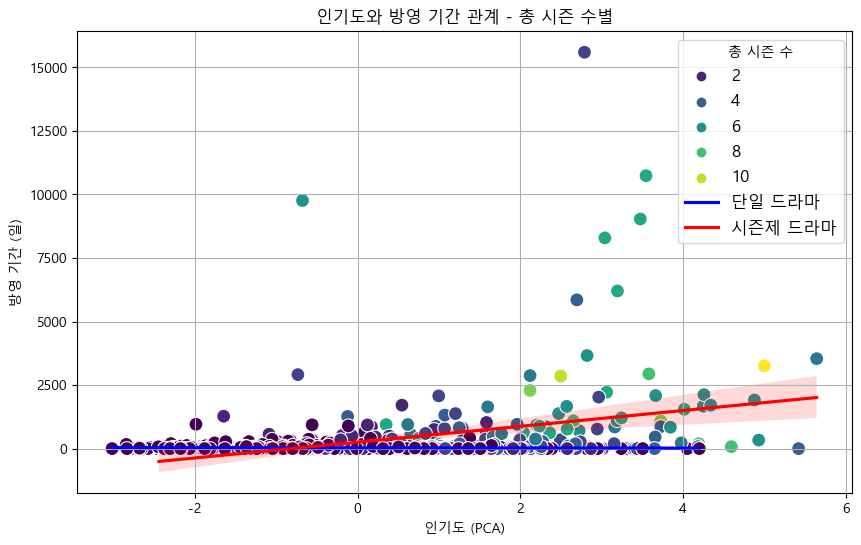

In [74]:
# 그래프 사이즈 설정
plt.figure(figsize=(10, 6))

# scatterplot with hue
sns.scatterplot(x='pca', y='s1_gap_days', hue='total_season_num', data=df, palette='viridis', s=100)

# regplot for 1 season
sns.regplot(x='pca', y='s1_gap_days', data=df[df['total_season_num'] == 1], scatter=False, color='blue', label='단일 드라마')

# regplot for 2+ seasons
sns.regplot(x='pca', y='s1_gap_days', data=df[df['total_season_num'] >= 2], scatter=False, color='red', label='시즌제 드라마')

plt.title('인기도와 방영 기간 관계 - 총 시즌 수별')
plt.xlabel('인기도 (PCA)')
plt.ylabel('방영 기간 (일)')
plt.legend(title='총 시즌 수', fontsize='large')  # 범례 폰트 사이즈 조절
plt.grid(True)
plt.show()

### 02. 시즌제 드라마의 시즌 간의 term 비교 
    - 한 작품의 시즌간 term의 평균값으로 시각화

In [75]:
import pandas as pd
from datetime import datetime

# 시즌 컬럼 리스트 생성
season_columns = [f'season_{i}' for i in range(1, 12)]  # 시즌 1부터 시즌 11까지
season_gaps = []

for idx, row in df.iterrows():
    seasons = []

    # 시즌 데이터를 추출하여 리스트에 추가
    for season_col in season_columns:
        if season_col in row and pd.notnull(row[season_col]):
            season_data = row[season_col]
            seasons.append(season_data)

    # 시즌 간격을 계산
    if len(seasons) > 1:
        # 각 드라마에 대해 시즌 간격을 계산
        for i in range(len(seasons) - 1):
            try:
                # 현재 시즌의 마지막 에피소드 방영일자
                last_episode_current_season = list(seasons[i].values())[-1][2]
                if last_episode_current_season:
                    last_air_date = datetime.strptime(last_episode_current_season, "%a, %b %d, %Y")
                else:
                    continue
                
                # 다음 시즌의 첫 번째 에피소드 방영일자
                first_episode_next_season = list(seasons[i + 1].values())[0][2]
                if first_episode_next_season:
                    next_air_date = datetime.strptime(first_episode_next_season, "%a, %b %d, %Y")
                else:
                    continue
                
                # 시즌 간의 간격 계산
                gap_days = (next_air_date - last_air_date).days
                gap_years_months = f"{gap_days // 365}년 {gap_days % 365 // 30}개월"
                
                # 결과 저장
                season_gaps.append({
                    'korean_title': row['korean_title'],
                    'english_title': row['english_title'],
                    'year': row['year'],
                    'season': f"Season {i + 1} to Season {i + 2}",
                    'gap_days': gap_days,
                    'gap_years_months': gap_years_months
                })
            except KeyError as e:
                print(f"KeyError: {e} in row {idx} for season {i + 1} to season {i + 2}")
            except ValueError as e:
                print(f"ValueError: {e} in row {idx} for season {i + 1} to season {i + 2}")

# 결과 데이터 프레임 생성
season_gaps_df = pd.DataFrame(season_gaps)

# 중복된 행 제거
season_gaps_df = season_gaps_df.drop_duplicates()

In [76]:
# Calculate the mean of 'gap_days' grouped by 'korean_title'
grouped = season_gaps_df.groupby('korean_title')['gap_days'].mean().reset_index()

# Merge with original dataframe to get 'english_title' and 'year'
merged = grouped.merge(season_gaps_df[['korean_title', 'english_title', 'year']], on='korean_title', how='left')

# Drop duplicates to keep only unique rows
merged = merged.drop_duplicates(subset=['korean_title'])

# Rename columns for clarity
merged.rename(columns={'gap_days': 'average_gap_days'}, inplace=True)

# Print the new DataFrame
print(merged.head())

      korean_title  average_gap_days             english_title  year
0               3%        452.666667                        3%  2016
3            A 리스트        974.000000                The A List  2018
4             D.P.        700.000000                      D.P.  2021
5   DC 레전드 오브 투모로우        190.500000  DC's Legends of Tomorrow  2016
11          DC 타이탄        419.666667                    Titans  2018


In [77]:
# 'korean_title'을 기준으로 두 데이터프레임을 merge
merged_data = pd.merge(df, merged, on=['korean_title','english_title','year'])

In [78]:
merged_data[['korean_title','average_gap_days']]

,korean_title,average_gap_days
0,스위트 투스: 사슴뿔을 가진 소년,692.000000
1,스위트홈,1078.000000
2,굿 닥터,169.400000
3,워킹 데드,201.600000
4,"비르기트: 왕국, 권력, 영광",1321.333333
...,...,...
261,꽃들의 집,224.000000
262,우리가 몰랐던 그녀,819.000000
263,악플러는 꺼져주세요,371.000000
264,거짓말의 거짓말,728.000000


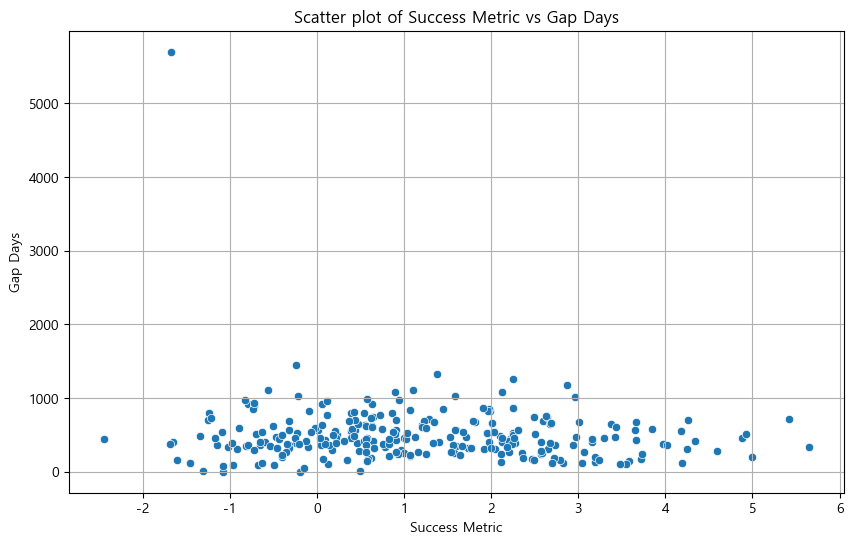

In [79]:
# Scatter plot using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca', y='average_gap_days', data=merged_data)
plt.title('Scatter plot of Success Metric vs Gap Days')
plt.xlabel('Success Metric')
plt.ylabel('Gap Days')
plt.grid(True)
plt.show()

### + 특이값 제외하고 다시 비교

In [80]:
merged_data = merged_data[merged_data['average_gap_days'] <= 5000]

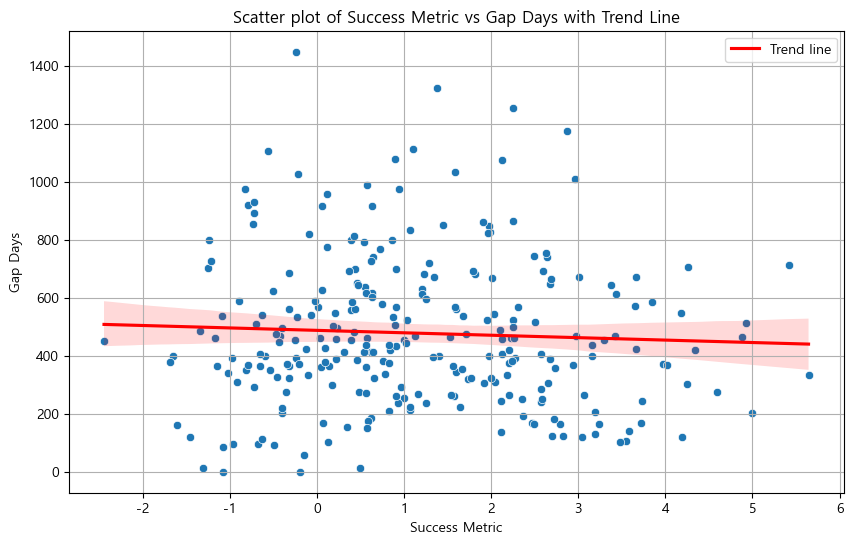

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca', y='average_gap_days', data=merged_data)
sns.regplot(x='pca', y='average_gap_days', data=merged_data, scatter=False, color='red', label='Trend line')
plt.title('Scatter plot of Success Metric vs Gap Days with Trend Line')
plt.xlabel('Success Metric')
plt.ylabel('Gap Days')
plt.legend()
plt.grid(True)
plt.show()